## Objective
The rising potential of this comparatively under-the-radar market fuels the need for an ML-based solution to develop a dynamic pricing strategy for used and refurbished devices. ReCell, a startup aiming to tap the potential in this market, has hired you as a data scientist. 

They want you to **analyze** the data provided and **build a linear regression model** to predict the price of a used phone/tablet and **identify factors** that significantly influence it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
df = pd.read_csv("used_device_data.csv")
df.head()

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


# Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand_name             3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   main_camera_mp         3275 non-null   float64
 6   selfie_camera_mp       3452 non-null   float64
 7   int_memory             3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

In [4]:
df.isnull().sum()

brand_name                 0
os                         0
screen_size                0
4g                         0
5g                         0
main_camera_mp           179
selfie_camera_mp           2
int_memory                 4
ram                        4
battery                    6
weight                     7
release_year               0
days_used                  0
normalized_used_price      0
normalized_new_price       0
dtype: int64

In [5]:
a = df[df['battery'].isnull() == True]

a['os'].unique()

array(['Android', 'Windows', 'Others'], dtype=object)

In [6]:
# Filling Missing Values
# Different OS types might have significantly different camera capabilities etc. I'll be filling the Nan values based on their OS mean

os_main_camera_mean = df.groupby('os')['main_camera_mp'].mean().round(2)
df['main_camera_mp'] = df['main_camera_mp'].fillna(df['os'].map(os_main_camera_mean))


os_selfie_camera_mean = df.groupby('os')['selfie_camera_mp'].mean().round(2)
df['selfie_camera_mp'] = df['selfie_camera_mp'].fillna(df['os'].map(os_selfie_camera_mean))


os_int_memory_mean = df.groupby('os')['int_memory'].mean().round(2)
df['int_memory'] = df['int_memory'].fillna(df['os'].map(os_int_memory_mean))


os_ram_mean = df.groupby('os')['ram'].mean().round(2)
df['ram'] = df['ram'].fillna(df['os'].map(os_ram_mean))


os_battery_mean = df.groupby('os')['battery'].mean().round(2)
df['battery'] = df['battery'].fillna(df['os'].map(os_battery_mean))


os_weight_mean = df.groupby('os')['weight'].mean().round(2)
df['weight'] = df['weight'].fillna(df['os'].map(os_weight_mean))

In [7]:
df.isnull().sum()

brand_name               0
os                       0
screen_size              0
4g                       0
5g                       0
main_camera_mp           0
selfie_camera_mp         0
int_memory               0
ram                      0
battery                  0
weight                   0
release_year             0
days_used                0
normalized_used_price    0
normalized_new_price     0
dtype: int64

In [8]:
df[df.duplicated()]

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price


# Descriptive Analysis

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
screen_size,3454.0,13.713115,3.805280,5.080000,12.700000,12.830000,15.340000,30.710000
main_camera_mp,3454.0,9.476262,4.689489,0.080000,5.000000,9.770000,13.000000,48.000000
selfie_camera_mp,3454.0,6.554424,6.968358,0.000000,2.000000,5.000000,8.000000,32.000000
int_memory,3454.0,54.581503,84.923499,0.010000,16.000000,32.000000,64.000000,1024.000000
ram,3454.0,4.033602,1.366320,0.020000,4.000000,4.000000,4.000000,12.000000
battery,3454.0,3132.372646,1299.091271,500.000000,2100.000000,3000.000000,4000.000000,9720.000000
weight,3454.0,182.747782,88.324365,69.000000,142.000000,160.000000,185.000000,855.000000
release_year,3454.0,2015.965258,2.298455,2013.000000,2014.000000,2015.500000,2018.000000,2020.000000
days_used,3454.0,674.869716,248.580166,91.000000,533.500000,690.500000,868.750000,1094.000000
normalized_used_price,3454.0,4.364712,0.588914,1.536867,4.033931,4.405133,4.755700,6.619433


In [10]:
df.describe(include='object').T

,count,unique,top,freq
brand_name,3454,34,Others,502
os,3454,4,Android,3214
4g,3454,2,yes,2335
5g,3454,2,no,3302


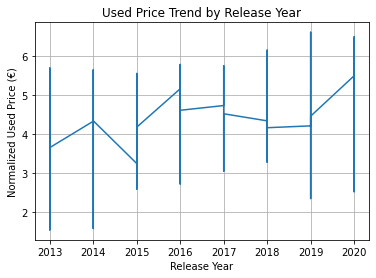

In [11]:
df_sorted = df.sort_values(by='release_year')
plt.plot(df_sorted['release_year'].values, df_sorted['normalized_used_price'].values)
plt.xlabel("Release Year")
plt.ylabel("Normalized Used Price (€)")
plt.title("Used Price Trend by Release Year")
plt.grid(True)
plt.show()


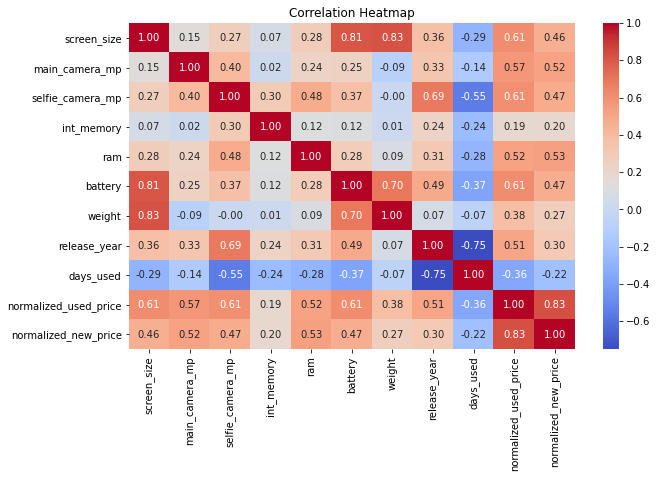

In [12]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()